<center><h1><b>Proyecto de Curso Aprendizaje Automático</b></h1>
<h2><b>Escuela de Posgrado PUCP</b></h2>
<h2><b>Maestría en Informática</b></h2></center>

**<h2>Importación de Librerías</h2>**


In [1]:
#Procesamiento y manejo de data
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#Gráficos
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import altair as alt
import seaborn as sns

#Modelos
from sklearn import naive_bayes
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from ANN_util import FeedForwardNeuralNetwork, ANNArchitecture
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Validación y selección de características
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Librerías varias
from sklearn import pipeline
from sklearn import model_selection
import random
import itertools
import tensorflow as tf
#Metricas
from sklearn.metrics import confusion_matrix, classification_report

matplotlib.rcParams['figure.dpi'] = 100

**<h2>Lectura de la data</h2>**

El conjunto de datos consta de los niveles de expresión de 77 proteínas que produjeron señales detectables en la parte nuclear del córtex (características continuas). Se tienen 38 ratones  sanos  y  34  ratones trisómicos  organizados en ocho clases (cada uno conformado por entre  7  y  10  ratones).  Por cada ratón se  han  tomado 15  muestras, por  ende, se tendrán 570 y  510 muestras para los ratones sanos y trisómicos respectivamente.

In [2]:
dataset = pd.read_excel("Data_Cortex_Nuclear.xls")

In [3]:
print(f"Las dimensiones del dataset son {dataset.shape}")
dataset.head()

Las dimensiones del dataset son (1080, 82)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**<h2>Preprocesamiento</h2>**

La estrategia que se utilizará para el manejo de datos faltantes será la imputación de los mismos por el estadístico media para cada clase.

**<h3>Eliminación de Características innecesarias y codificación de la clase</h3>**

In [4]:
preprocDataset = dataset.copy()

#Se elimina información redundante "Genotype", "Treatment", "Behavior" que ya están combinadas en la columna clase.
preprocDataset.drop(["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

#Se separan las versiones y números de ratones en otras variables
MouseNumber = preprocDataset.MouseID.apply(lambda x: x.split('_')[0])
MouseVersion = preprocDataset.MouseID.apply(lambda x: x.split('_')[1])

#Se elimina información irrelevante para la tarea de clasificación multiclase
preprocDataset.drop("MouseID", axis=1, inplace=True)

preprocDataset["class"] = LabelEncoder().fit_transform(preprocDataset["class"])

**<h3>Imputación de datos faltantes</h3>**

Dado que se aplicará validación K-Fold durante la búsqueda y optimización de cada hiperparámetro, se realizará la imputación de datos faltantes durante cada iteración de validación, mediante el uso de un imputador que usa la mediana de cada característica, dicho imputador será agregado al inicio del pipeline de entrenamiento.

**<h2> Separación y etiquetado de datos</h2>**

In [5]:
x = preprocDataset.drop("class",axis=1)
y = preprocDataset["class"]

**<h3>Análisis de separabilidad de la data</h3>**

In [6]:
#Imputacion temporal del dataset para realizar el gráfico T-SNE.
x_imputed = SimpleImputer(strategy="mean").fit_transform(x)
x_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(x_imputed)

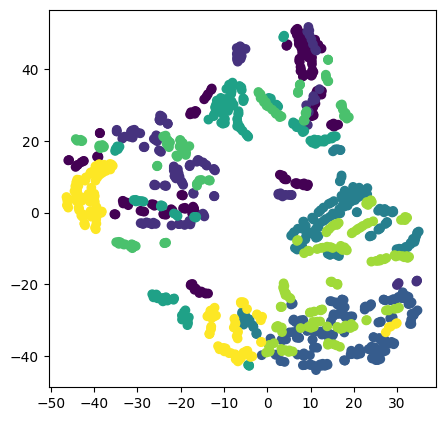

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y)
plt.show()

Se observa del gráfico t-SNE que las clases de los datos están medianamente separados, por tanto, se espera que los modelos a entrenar tengan una precisión razonablemente alta.

**<h2>Separación de conjunto de entrenamiento de conjunto de pruebas</h2>**

In [8]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.8,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_test.shape}.")

El tamaño del conjunto de prueba es: (864, 77).
El tamaño del conjunto de prueba es: (216, 77).


## Escalamiento de data

Se utilizará la clase ***pipeline*** para realizar el escalamiento sólo en la data de entrenamiento correspondiente a la validación ***k-fold***, dicho ***pipeline*** se definirá previo al entrenamiento de cada modelo.

# Implementación de artículo del estado del arte

A continuación, se presenta la implementación en Python utilizando scikit-learn del artículo titulado "Random Forest Modeling For Mice Down Syndrome Through Protein Expression: A Supervised Learning Approach". En este artículo se detalla la implementación en el lenguaje de programación R del método Random Forest para clasificación de proteínas utilizando el Mice Protein Expression Data Set, y es uno de los pocos que provee información para replicar sus resultados de forma bastante aproximada.

## Preprocesamiento de datos

Se considera un preprocesamiento simple, tal y como se da a entender en el artículo. Este preprocesamiento consiste en eliminar la característica "MouseID" que es un identificador, y por tano, no aporta al modelo. Por otro lado, cabe mencionar que se utilizan las características "Genotype", "Treatment" y "Behavior" que combinadas forman la clase a la cual pertenece el ratón, lo cual va a ocasionar Data Leakage.

In [9]:
#Lectura del dataset
preprocDataset_stt = dataset.copy()

#Columna descartada por no tener información relevante
preprocDataset_stt.drop("MouseID", axis=1, inplace=True)

#Conversión de datos categóricos a numéricos
preprocDataset_stt["class"] = LabelEncoder().fit_transform(preprocDataset_stt["class"])
preprocDataset_stt["Genotype"] = LabelEncoder().fit_transform(preprocDataset_stt["Genotype"])
preprocDataset_stt["Treatment"] = LabelEncoder().fit_transform(preprocDataset_stt["Treatment"])
preprocDataset_stt["Behavior"] = LabelEncoder().fit_transform(preprocDataset_stt["Behavior"])

#Características (features) y etiquetas (labels)
x = preprocDataset_stt.drop("class",axis=1)
y = preprocDataset_stt["class"]

## Partición de sets de entrenamiento y prueba

Tal y como se menciona en el artículo, se utiliza un 70% de los datos para entrenamiento y 30% como conjunto de prueba.

In [10]:
x_stt_train, x_stt_test, y_stt_train, y_stt_test = model_selection.train_test_split(x, y, train_size=0.7,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_stt_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_stt_test.shape}.")

El tamaño del conjunto de prueba es: (756, 80).
El tamaño del conjunto de prueba es: (324, 80).


## Modelo a implementar

En el artículo se presenta un modelo de Random Forest de 50 estimadores y 8 características para la mejor separación en los nodos de cada estimador. También es importante mencionar que usa un método de imputación para valores NA utilizando la mediana de los datos.

In [10]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
stt_imputer = SimpleImputer(strategy='median')
stt_scaler = preprocessing.StandardScaler()
stt_pipeline = pipeline.Pipeline([("imputer", stt_imputer), ("scaler", stt_scaler)])

stt_pipeline.fit(x_stt_train)

x_train_model = stt_pipeline.transform(x_stt_train)

stt_model = RandomForestClassifier(n_estimators=50, max_features=8, criterion='entropy', class_weight="balanced", random_state=0, oob_score=True)
stt_model.fit(x_train_model, y_stt_train)

x_test_model = stt_pipeline.transform(x_stt_test)

oob_error = 1 - stt_model.oob_score_
train_stt_score = stt_model.score(x_train_model, y_stt_train)
test_stt_score = stt_model.score(x_test_model, y_stt_test)

print(f"La exactitud de entrenamiento para el modelo del estado del arte es: {train_stt_score}.")
print(f"La exactitud de prueba para el modelo del estado del arte es: {test_stt_score}.")
print(f"Error OOB obtenido por el modelo del estado del arte es: {oob_error}.")

La exactitud de entrenamiento para el modelo del estado del arte es: 1.0.
La exactitud de prueba para el modelo del estado del arte es: 1.0.
Error OOB obtenido por el modelo del estado del arte es: 0.001322751322751281.


El resultado indica que el modelo planteado en el artículo ha sido reproducido adecuadamente. Diferencias presentes han ocurrido debido a las diferencias entre las implementaciones de Python y R de Random Forest. or otro lado, se observa que el modelo del artículo efectivamente ha incurrido en Data Leakage.

### Gráfico de matriz de confusion

In [11]:
class_names = set(dataset["class"].values)
plt.rcParams.update({'font.size': 8})

In [12]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          title='Matriz de confusion',
                          cmap=plt.cm.RdYlGn, isforNN=False):
    '''
    Se ha tomado como referencia el siguiente script https://stackoverflow.com/a/50386871
    '''
    if isforNN:
        cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=8).numpy()
    else:
        cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predecida')

# Algoritmos a entrenar

## Decision Tree

Se ha usado como punto de partida un modelo de árbol de decisión (DT), debido a su facilidad de aplicación. Para esto se ha implementado un pipeline para mantener el orden y poder realizar el escalamiento en la data de entrenamiento. Se ha empleado un método de imputación basado en la media, un escalamiento escalar de los datos y un balanceo de pesos propio del mismo algoritmo DecisionTree de SKLearn. Para la búsqueda de hiperparámetros se ha utilizado una búsqueda aleatoria (RandomizedSearchCV), definiendo el criterio (impureza de gini y entropía), máxima profundidad y número mínimo de muestras para dividir un nodo.

In [11]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
dt_imputer = SimpleImputer(strategy='mean')
dt_scaler = preprocessing.StandardScaler()
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=0)

dt_pipeline = pipeline.Pipeline([("imputer", dt_imputer), ("scaler", dt_scaler), ("dt", dt_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_dt = {'dt__criterion': ['gini', 'entropy'],
           'dt__max_depth': range(1, 31, 3),
           'dt__min_samples_split': range(2, 80, 1)}

In [12]:
#Busqueda aleatoria
r_search_dt = model_selection.RandomizedSearchCV(dt_pipeline,
                                                 grid_dt,
                                                 n_iter=80,
                                                 n_jobs=-1,
                                                 random_state=0)

r_search_dt.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('dt',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__max_depth': range(1, 31, 3),
                                        'dt__min_samples_split': range(2, 80)},
                   random_state=0)

In [13]:
best_dt_pipeline = r_search_dt.best_estimator_

train_score = best_dt_pipeline.score(x_train, y_train)
test_score = best_dt_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo DT es: {train_score}.")
print(f"La exactitud de prueba para el modelo DT es: {test_score}.")

La exactitud de entrenamiento para el modelo DT es: 0.9953703703703703.
La exactitud de prueba para el modelo DT es: 0.875.


In [14]:
best_dt_params = best_dt_pipeline["dt"].get_params()
best_dt_params

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 28,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

A partir de los resultados del ajuste de hiperparámetros de la validación cruzada, se han obtenido los parámetros y la media de las exactitudes. De esta forma, se podrán visualizar los resultados usando la librería altair. La gráfica muestra que el criterio de ganancia de información utilizado son bastante similares.

In [15]:
results_dt = pd.DataFrame(r_search_dt.cv_results_['params'])
results_dt['test_score'] = r_search_dt.cv_results_['mean_test_score']
results_dt.head()

,dt__min_samples_split,dt__max_depth,dt__criterion,test_score
0,9,13,gini,0.811299
1,29,10,entropy,0.777786
2,20,1,entropy,0.234985
3,35,22,gini,0.749946
4,26,16,gini,0.759208


In [16]:
alt.Chart(results_dt, 
          title='Comparacion de performance DT'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Profundidad maxima'),
    alt.Y('test_score', title='Score Medio CV', aggregate='average', scale=alt.Scale(zero=False)),
    color='dt__criterion'
)

alt.Chart(...)

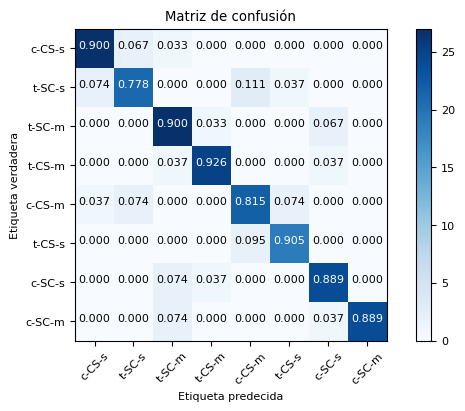

In [78]:
y_pred = best_dt_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

## Random Forest

Se ha usado Random Forest (RF) como un método que construye muchos árboles de decisión y cada árbol emite un voto por alguna entrada. RF utiliza muchos árboles para superar la alta dimensionalidad de los datos. Para la implementación de este modelo, se aplicó un proceso de validación cruzada con imputación de media y escalamiento estandar. Se ha realizado un balanceo de datos y se ha utilizado el criterio de impureza de gini. Además, se ha utilizado un pipeline para mantener un orden en la secuencia de pasos. Para la búsqueda de hiperparámetros, se ha utilizado una búsqueda aleatoria (RandomizedSearchCV), definiendo el número de estimadores, máxima profundidad, número mínimo de muestras para dividir un nodo y mínimo de muestras por hoja.

In [39]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced", criterion="gini", random_state=0)

rfc_pipeline = pipeline.Pipeline([("imputer", rfc_imputer),("scaler", rfc_scaler), ("rfc", rfc_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_rfc = {"rfc__n_estimators": range(1,1200,20), 
            "rfc__max_depth": range(1,31,3),
            "rfc__min_samples_split": range(2, 80, 2),
            "rfc__min_samples_leaf": range(1, 20, 1)}

In [40]:
#Busqueda aleatoria
r_search_rfc = model_selection.RandomizedSearchCV(rfc_pipeline, 
                                                  grid_rfc, 
                                                  n_iter=60, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'rfc__max_depth': range(1, 31, 3),
                                        'rfc__min_samples_leaf': range(1, 20),
                                        'rfc__min_samples_split': range(2, 80, 2),
                                        'rfc__n_estimators': range(1, 1200, 20)},
                   random_state=0)

In [43]:
best_rfc_pipeline = r_search_rfc.best_estimator_

train_score = best_rfc_pipeline.score(x_train, y_train)
test_score = best_rfc_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo RF es: {train_score}.")
print(f"La exactitud de prueba para el modelo RF es: {test_score}.")

La exactitud de entrenamiento para el modelo RF es: 1.0.
La exactitud de prueba para el modelo RF es: 0.9814814814814815.


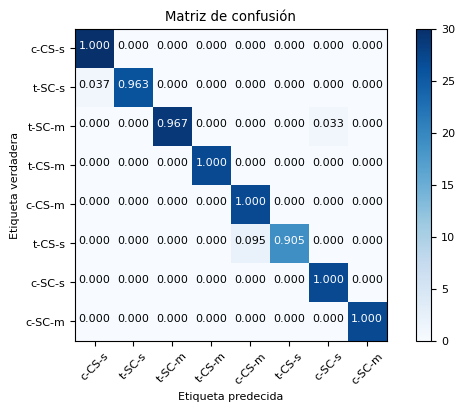

In [81]:
y_pred = best_rfc_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

#### Eliminación hacia atrás

Utilizando el mejor modelo de clasificación a partir de la búsqueda aleatoria de hiperparámetros, se ha buscado el número óptimo de características utilizando el método de clasificación de funciones y selección con validación cruzada RFECV. Si bien en los demás modelos utilizados se ha obtenido 77 características óptimas, se cree que en este modelo se han obtenido más debido a que es un modelo de ensamble que desagrega el dataset y complica la identificación de la cantidad óptima de características.

In [ ]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced",random_state=0)

imsc_imputer = rfc_imputer
imsc_scaler = rfc_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

x_train_imsc = imsc_pipeline.transform(x_train)

best_rfc_params = best_rfc_pipeline["rfc"].get_params()
best_rfc_model = RandomForestClassifier().set_params(**best_rfc_params)

rfecv = RFECV(estimator=best_rfc_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características: %d" % x_train_opt.shape[1])

## KNN

Se ha empleado el algoritmo de clasificación KNN, debido a que es bastante utilizado en el diagnóstico de enfermedades cardiacas, además es uno de los que menos tiempo de proceso requiere en comparación a los demás modelos seleccionados.
Al igual que los otros modelos, se ha empleado una imputación con media, escalamiento estandar y un pipeline. Los hiperparámetros se han optimizado con una búsqueda aleatoria y se han realizado un total de 360 iteraciones, buscando el modelo óptimo según la cantidad de vecinos próximos, tamaño de cada hoja, los pesos y los algoritmos utilizados.

In [45]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
knn_imputer = SimpleImputer(strategy='mean')
knn_scaler = preprocessing.StandardScaler()
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_pipeline = pipeline.Pipeline([("imputer", knn_imputer),("scaler", knn_scaler), ("knn", knn_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_knn = {"knn__n_neighbors": range(1,10,1),
            "knn__leaf_size": range(1,6,1),
            "knn__weights": ['uniform', 'distance'],
            "knn__algorithm": ['auto', 'ball_tree','kd_tree','brute']}

In [46]:
#Busqueda aleatoria
r_search_knn = model_selection.RandomizedSearchCV(knn_pipeline, 
                                                  grid_knn, 
                                                  n_iter=360, 
                                                  n_jobs=-1,
                                                  cv=8, 
                                                  random_state=0)
r_search_knn.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=360, n_jobs=-1,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__leaf_size': range(1, 6),
                                        'knn__n_neighbors': range(1, 10),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=0)

In [47]:
best_knn_pipeline = r_search_knn.best_estimator_

train_score = best_knn_pipeline.score(x_train, y_train)
test_score = best_knn_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo KNN es: {train_score}.")
print(f"La exactitud de prueba para el modelo KNN es: {test_score}.")

La exactitud de entrenamiento para el modelo KNN es: 1.0.
La exactitud de prueba para el modelo KNN es: 0.9953703703703703.


In [48]:
best_knn_params = best_knn_pipeline["knn"].get_params()
best_knn_params

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

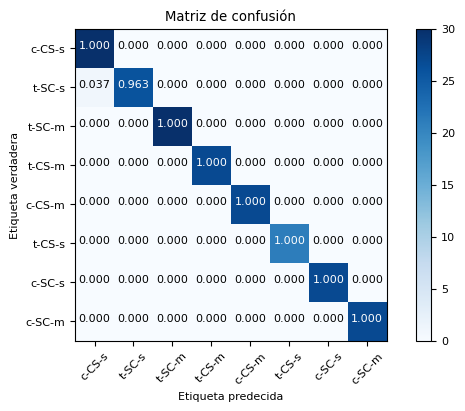

In [82]:
y_pred = best_knn_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

No se realizó una eliminación hacia atrás para determinar las principales características, debido a que el modelo KNN no tiene atributos **coef_** o **feature_importances_**, que son requeridas por el selector RFECV.

## Support Vector Machine

Primero se intentará con una svm lineal, para lo cual se le aplicará una búsqueda de grilla a un pipeline de imputador, escalador y clasificador.

### Linear SVM

In [50]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = LinearSVC(class_weight="balanced",random_state=0, max_iter=3000)#SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 2, num=20)
grid_svm = {"model__C":C}

#Busqueda aleatoria
grid_search = model_selection.GridSearchCV(svm_pipeline, grid_svm, n_jobs=-1,cv=8)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=3000,
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00e-04, 2.07e-04, 4.28e-04, 8.86e-04, 1.83e-03, 3.79e-03,
       7.85e-03, 1.62e-02, 3.36e-02, 6.95e-02, 1.44e-01, 2.98e-01,
       6.16e-01, 1.27e+00, 2.64e+00, 5.46e+00, 1.13e+01, 2.34e+01,
       4.83e+01, 1.00e+02])})

In [51]:
best_svm_pipeline = grid_search.best_estimator_

train_score = best_svm_pipeline.score(x_train, y_train)
test_score = best_svm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9814814814814815.


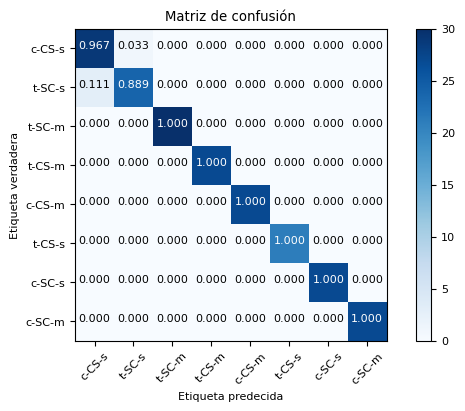

In [83]:
y_pred = best_svm_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

#### Eliminación hacia atrás

Debido a que la precisión de test puede mejorar, se realizará una selección de características por eliminación hacia atrás.

In [85]:
#Cabe resaltar que el selector RFECV no soporta el ingreso de datos de entrenamiento con valores faltantes, aún
#si el estimador es un pipeline con un imputador, para solucionar este problema, acá ya no se usa el pipeline
#por lo que se preprocesa la data antes de pasarlo al método fit del RFECV

transformation_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler)])
x_train_transformed = transformation_pipeline.fit_transform(x_train)
x_test_transformed = transformation_pipeline.transform(x_test)

#Utilizaré el modelo encontrado anteriormente
params = best_svm_pipeline["model"].get_params()
svm_model = LinearSVC()
svm_model.set_params(**params)

LinearSVC(C=0.615848211066026, class_weight='balanced', max_iter=3000,
          random_state=0)

In [86]:
rfecv = RFECV(estimator=svm_model, step=1, cv=8, scoring='accuracy')
rfecv.fit(x_train_transformed, y_train)

RFECV(cv=8,
      estimator=LinearSVC(C=0.615848211066026, class_weight='balanced',
                          max_iter=3000, random_state=0),
      scoring='accuracy')

In [87]:
train_score = rfecv.score(x_train_transformed, y_train)

test_score = rfecv.score(x_test_transformed, y_test)

print("Después de realizar la selección de características:")
print(f"la exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

Después de realizar la selección de características:
la exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9768518518518519.


In [88]:
print(f"Número óptimo de características : {rfecv.get_support().sum()}")

Número óptimo de características : 44


Podemos observar que la precisión de test disminuyó, esto se debe al hecho que el RFECV tiene una menor capacidad, en comparación a la búsqueda de grilla anterior, para encontrar el modelo que generaliza mejor, esto se debe al hecho de que se realiza la imputación a toda la data de entrenamiento y no sólo a la data de entrenamiento durante cada iteración de validación cruzada.

Como no se obtuvieron los resultados esperados al realizar la selección de características, entonces se implementará un clasificador SVM con una función de base radial como kernel.

### SVM con Kernel RBF

Para implementar esto se realizará un busqueda aleatoria haciendo uso de un pipeline de imputador, escalador y clasificador, pero ahora utilizando la selección de características obtenida con el SVM Lineal.


In [89]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
gamma = np.logspace(-4, 2, num=20)
C = np.logspace(-4, 2, num=20)
grid_svm = {"model__gamma":gamma, "model__C":C}

#Definición de la data reducida por la selección de características obtenida del linear SVM
x_train_reduced = x_train.iloc[:,rfecv.get_support()]
x_test_reduced = x_test.iloc[:,rfecv.get_support()]
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(svm_pipeline, grid_svm, n_iter=40,n_jobs=-1,cv=8, random_state=0)

In [90]:
r_search.fit(x_train_reduced, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              SVC(class_weight='balanced',
                                                  random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00e-04, 2.07e-04, 4.28e-04, 8.86e-04, 1.83e-03, 3.79e-03,
       7.85e-03, 1.62e-02, 3.36e-02, 6.95e-02, 1.44e-01, 2.98e-01,
       6.16e-01, 1.27e+00, 2.64e+00, 5.46e+00, 1.13e+01, 2.34e+01,
       4.83e+01, 1.00e+02]),
                                        'model__gamma': array([1.00e-04, 2.07e-04, 4.28e-04, 8.86e-04, 1.83e-03, 3.79e-03,
       7.85e-03, 1.62e-02, 3.36e-02, 6.95e-02, 1.44e-01, 2.98e-01,
       6.16e-01, 1.27e+00, 2.64e+00, 5.46e+00, 1.13e+01, 2.34e+01,
       4.83e+01, 1.00e+02])},
               

In [91]:
best_svm_pipeline = r_search.best_estimator_

train_score = best_svm_pipeline.score(x_train_reduced, y_train)
test_score = best_svm_pipeline.score(x_test_reduced, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 1.0.


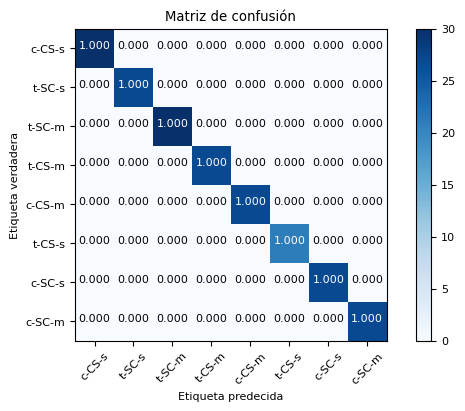

In [93]:
y_pred = best_svm_pipeline.predict(x_test_reduced)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

## Redes neuronales

Para implementar las redes neuronales, se aplicó un procedimiento de validación cruzada con imputación y escalamiento similar a los utilizados en los entrenamientos de los demás algoritmos, con excepción de que aquí la validación cruzada también puede ser usada para validar la inicialización de los pesos de la red neuronal para lograr así una mejor exactitud de validación; este método debe ser analizado con cuidado, ya que una exhaustiva selección del modelo que mejor prediga la data de validación puede provocar que se seleccione un modelo sobreajustado a la data de validación. Esto sucedió en un inicio y se pudo corroborar con la caída de la precisión de test, por lo tanto se decidió realizar solo una inicialización por arquitectura. 

En un inicio se hizo una búsqueda aleatoria con una cantidad de capas variable, pero se observó que la data puede ser fácilmente caracterizada con una red neuronal de solo dos capas ocultas, por tal motivo el número de capas se fijó a 2.

In [95]:
#Definición de arquitecturas
numberOfUnitsInHiddenLayer = range(8, 50)
numberOfLayers = [3] # Puede ser sustituido por una lista range(2, 7), en este caso no fue necesario
activationFunctionsHidden = ["tanh"]
# Se puede utilizar relu como función de activación para tener un entrenamiento más rápido, "relu", 
# en este caso no fue necesario.

In [96]:
ntries = 20 #Número de búsquedas aleatorias de arquitectura
NUM_EPOCHS = 10000
tries = set() #Set que guardará las arquitecturas ya probadas
random.seed(0)

for i in range(ntries):
    print(f"Iteración de búsqueda aleatoria {i+1}")
    print("---------------------------------------")
    while(True):
        nlayers = random.choice(numberOfLayers)
        
        #Genera una lista de números de neuronas para cada capa, teniendo en cuenta que este número debe ir 
        #decreciendo conforme se llegue a la capa de salida.
        numberOfUnitsPerLayer = [8]#Para generar la salida de 8 clases
        for j in range(nlayers-1):
            index = numberOfUnitsInHiddenLayer.index(numberOfUnitsPerLayer[0])
            new_index = numberOfUnitsInHiddenLayer.index(min(2*numberOfUnitsPerLayer[0], 49))
            newNumberOfUnits = random.choice(numberOfUnitsInHiddenLayer[index:new_index])
            numberOfUnitsPerLayer.insert(0, newNumberOfUnits)
            
        #Seleccionamos aleatoriamente las funciones de activación de cada capa, con excepción de la capa de salida
        #que siempre emplea una función de activación softmax, en esta implementación, por recomendación de Tensorflow
        #la función softmax es aplicada por la función de pérdida, por lo que la capa de salida será lineal(None)
        numberOfActivationFunctionsPerLayer = [random.choice(activationFunctionsHidden) for j in range(nlayers)]
        numberOfActivationFunctionsPerLayer[-1] = None

        arch_str = str(numberOfUnitsPerLayer)+str(numberOfActivationFunctionsPerLayer)
        if not (arch_str in tries):
            tries.add(arch_str)
            break
    
    print(f"Arquitectura: {numberOfUnitsPerLayer}. Activation Functions: {numberOfActivationFunctionsPerLayer}\n")
    arch = ANNArchitecture(numberOfUnitsPerLayer, numberOfActivationFunctionsPerLayer)
    redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
    
    redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=NUM_EPOCHS, minibatchSize=64, 
                      verbose=False, numberOfInitializations=1, cv=8, randomState=0)
    

    
print("Fin de búsqueda aleatoria de características con validación cruzada k-fold k=8")



Iteración de búsqueda aleatoria 1
---------------------------------------
Arquitectura: [14, 14, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9930555447936058 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:48. Número de épocas:140.

Costo de entrenamiento:0.01019977405667305. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 2
---------------------------------------
Arquitectura: [20, 15, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9953703656792641 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:39. Núm

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9837962985038757 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:36. Número de épocas:122.

Costo de entrenamiento:0.00990179181098938. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 17
---------------------------------------
Arquitectura: [11, 9, 8]. Activation Functions: ['tanh', 'tanh', None]

La mejor inicialización para esta arquitectura logró una exactitud de validación promedio: 0.9872685074806213 y una exactitud de entrenamiento promedio: 1.0.


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:50. Número de épocas:163.

Costo de entrenamiento:0.013096416369080544. Exactitud de entrenamiento:1.0.


Iteración de búsqueda aleatoria 18
-------------

La mejor arquitectura encontrada fue una red neuronal con dos capas ocultas con funciones de activación tangente hiperbólica, que tiene 20 neuronas en la primera capa oculta y con 15 neuronas en la segunda capa oculta, y finalmente 8 neuronas y una función de activación softmax en la capa de salida.

In [13]:
print(f"Arquitectura: 20-15-8. Activation Functions: tanh-tanh-softmax\n")

arch = ANNArchitecture([20, 15,8], ["tanh","tanh",None])
redNeuronal = FeedForwardNeuralNetwork(architecture=arch)
redNeuronal.fitCV(x_train, y_train, learningRate=0.001, numberOfEpochs=10000, minibatchSize=64, 
                  verbose=False, numberOfInitializations=1, cv=None, randomState=0)

Arquitectura: 20-15-8. Activation Functions: tanh-tanh-softmax


Entrenamiento del modelo que mejor exactitud de validación promedio tuvo usando toda la data de entrenamiento.
Tiempo Transcurrido:00:00:03. Número de épocas:15.

Costo de entrenamiento:0.001848480198532343. Exactitud de entrenamiento:1.0.




In [14]:
test_cost = redNeuronal.score(x_test, y_test)
print ("Test SCCE:", test_cost)

Test SCCE: 0.9953703880310059


Dado que la precisión de test lograda es bastante alta, no se realizará una selección de características para las redes neuronales porque sería excesivamente costoso.

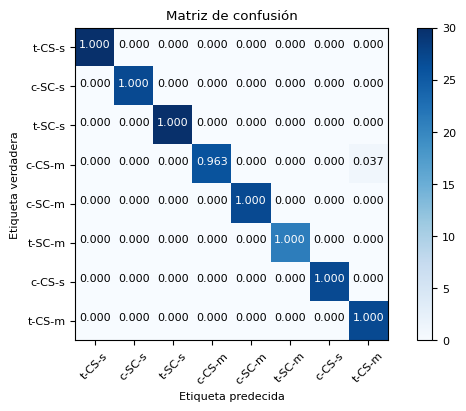

In [16]:
y_pred = redNeuronal.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues, isforNN=True)

## Naive Bayes

Se implementará Naive Bayes Gaussiano, se realizará una búsqueda aleatoria para las probabilidades a priori, aunque se puede deducir que el dejar que el algoritmo las cálcule probablemente sea lo óptimo.

In [103]:
random.seed(0)
#Definición de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
naive_imputer = SimpleImputer(strategy='mean')
naive_scaler = preprocessing.StandardScaler()
naive_model = naive_bayes.GaussianNB()
naive_pipeline = pipeline.Pipeline([("imputer",naive_imputer), ("scaler", naive_scaler), ("model", naive_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
priors = [None]

while(len(priors)<1000):
    priorsItem = []
    probabilityLeft = 1
    
    save = True
    for j in range(8):
        prob = random.uniform(0, probabilityLeft)
        if prob <=0.01:
            save = False
            break
        priorsItem.append(prob)
        probabilityLeft -= prob
    
    if (0 not in priorsItem) and save:
        priors.append(priorsItem)

grid_naive = {"model__priors":priors}

In [104]:
#Busqueda de grilla
grid_search =model_selection.GridSearchCV(naive_pipeline, grid_naive, n_jobs=-1,cv=8)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', GaussianNB())]),
             n_jobs=-1,
             param_grid={'model__priors': [None,
                                           [0.42561883196681716,
                                            0.05829981455975992,
                                            0.13413980851894763,
                                            0.08434387305772524,
                                            0.19252358811312115,
                                            0.03680681767912299,
                                            0.012309810167133287,
                                            0.028182217548734585],
                                           [0.40862622118314...
                                            0.03169835559401494,
                                            0.027751

In [105]:
grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', GaussianNB())])

In [106]:
best_naive_pipeline = grid_search.best_estimator_

train_score = best_naive_pipeline.score(x_train, y_train)
test_score = best_naive_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: {train_score}.")
print(f"La exactitud de prueba para el modelo naive Bayes Gaussiano es: {test_score}.")

La exactitud de entrenamiento para el modelo naive Bayes Gaussiano es: 0.8032407407407407.
La exactitud de prueba para el modelo naive Bayes Gaussiano es: 0.8148148148148148.


No se realizó eliminación hacia atrás debido a que el modelo Gaussian Naive Bayes no tiene los atributos coef_ o feature_importances_, atributos que son utilizados por el selector de características RFECV de Sklearn. Se probó con la selección de características de SVM, pero se obtuvo error de test mucho mayor.

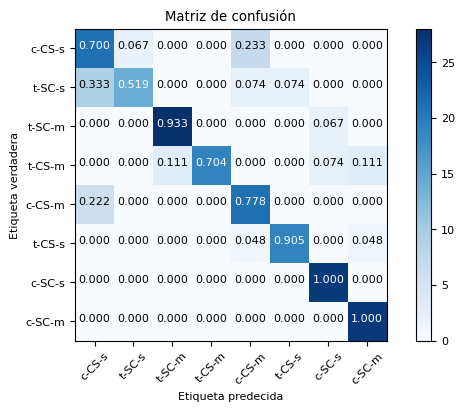

In [108]:
y_pred = best_naive_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

## Regresión Logística

Se implementa Regresión Logística y se ajusta el parámetro C (asociado a la fuerza de "regularización") mediante búsqueda aleatoria. De manera similar a los modelos anteriores, se realiza imputación y escalamiento a los datos para su preprocesamiento. Cabe resaltar que la regresión logística implementada utiliza la función softmax a la salida.

In [109]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lr_imputer = SimpleImputer(strategy='mean')
lr_scaler = preprocessing.StandardScaler()
lr_model = LogisticRegression(penalty="l2", class_weight="balanced", solver="lbfgs", random_state=47, max_iter=600)
lr_pipeline = pipeline.Pipeline([("imputer", lr_imputer), ("scaler", lr_scaler), ("model", lr_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 4, num=401)

grid_lr = {"model__C":C}

In [110]:
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(lr_pipeline, grid_lr, n_iter=40, n_jobs=-1, cv=8, random_state=47)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=600,
                                                                 random_state=47))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00e-04, 1.05e-04, 1.10e-04, 1.15e-04, 1.20e-04, 1.26e-04,
       1.32e-04, 1.38e-04, 1.45e-04, 1.51e-04, 1.58e-04, 1...
       1.58e+03, 1.66e+03, 1.74e+03, 1.82e+03, 1.91e+03, 2.00e+03,
       2.09e+03, 2.19e+03, 2.29e+03, 2.40e+03, 2.51e+03, 2.63e+03,
       2.75e+03, 2.88e+03, 3.02e+03, 3.16e+03, 3.31e+03, 3.47e+03,
       3.63e+03, 3.80e+03, 3.98e+03, 4.17e+03, 4.37e+03, 4.57e+03,
       4.79e+03, 5.01e+03

In [111]:
best_lr_pipeline = r_search.best_estimator_

train_score = best_lr_pipeline.score(x_train, y_train)
test_score = best_lr_pipeline.score(x_test, y_test)

print("Después de seleccionar características...")
print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el Regresión Logística es: {test_score}.")

Después de seleccionar características...
La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el Regresión Logística es: 0.9861111111111112.


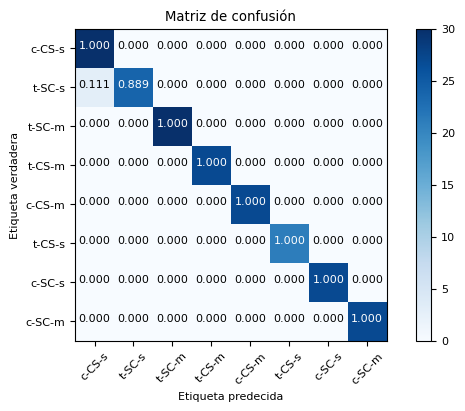

In [112]:
y_pred = best_lr_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

### Eliminación hacia atrás

Se emplea la estrategia de eliminación hacia atrás para selección de parámetros. Para ello, se crea un pequeño pipeline con solo el imputador y el escalador,y luego se aplica la eliminación hacia atrás solo al mejor modelo hallado en la búsqueda aleaoria.

In [51]:
#Definicion de imputación y escalamiento para datos y agrupación en pipeline
imsc_imputer = lr_imputer
imsc_scaler = lr_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])
imsc_pipeline.fit(x_train)

#Aplicación del pipeline para obtener data aplicable para el modelo de eliminación hacia atrás
x_train_imsc = imsc_pipeline.transform(x_train)

#Mejor modelo obtenido para Regresión Logística
best_model = best_lr_pipeline["model"]

#Eliminación hacia atrás para el mejor modelo
rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

#Transformación de datos de entrenamiento
x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

Número óptimo de características : 69


In [52]:
#Entrenando con las características óptimas en entrenamiento (como parámetro warm_start es FALSE, se entrena de nuevo)
best_model.fit(x_train_opt, y_train)

#Transformación de datos de prueba
x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Exactitud del modelo en conjuntos de entrenamiento y prueba
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el modelo Regresión Logística es: 0.9814814814814815.


## LightGBM

Se ha implementado LightGBM siguiendo las recomendaciones expresadas en https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html, donde se presentan distintas estrategias dependiendo del objetivo deseado. En este caso particular, se optó porla estrategia para mejor exactitud, por lo tanto, se ha seguido lo siguiente:
- Alto max_bin.
- Bajo learning_rate con alto num_iterations.
- Alto num_leaves.

Se ha descartado el uso de DART (en boosting_type) debido a que se ha comprobado (de forma empírica) que requiere más recursos computacionales (memoria). De manera similar a modelosprevios, se utilizará un imputador y un escalador para preprocesamiento de datos y se determinará el mejor modelo por búsqueda aleatoria.

In [113]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lgbm_imputer = SimpleImputer(strategy='mean')
lgbm_scaler = preprocessing.StandardScaler()
lgbm_model = LGBMClassifier()
lgbm_pipeline = pipeline.Pipeline([("imputer", lgbm_imputer), ("scaler", lgbm_scaler), ("lgbm", lgbm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_lgbm = {"lgbm__max_bin": np.power(2, range(7,10,3)), 
             "lgbm__learning_rate": [2.5e-3,5-3,7.5e-3,1e-2],
             "lgbm__num_leaves": range(250, 500, 25),
             "lgbm__num_iterations": [500]}

In [114]:
lgbm_search = model_selection.RandomizedSearchCV(lgbm_pipeline, grid_lgbm, n_iter=20, n_jobs=-1, cv=8, random_state=47)
lgbm_search.fit(x_train, y_train)

e:\2020\maestria\ciclo_01\02_ml\proyectoinf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.0025, 2,
                                                                0.0075, 0.01],
                                        'lgbm__max_bin': array([128], dtype=int32),
                                        'lgbm__num_iterations': [500],
                                        'lgbm__num_leaves': range(250, 500, 25)},
                   random_state=47)

In [115]:
best_lgbm_pipeline = lgbm_search.best_estimator_

#Exactitud en conjuntos de entrenamiento y prueba
train_score = best_lgbm_pipeline.score(x_train, y_train)
test_score = best_lgbm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo LightGBM: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM: 1.0.
La exactitud de prueba para el modelo LightGBM: 0.9537037037037037.


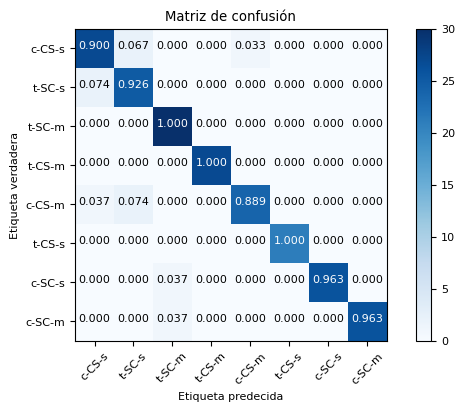

In [116]:
y_pred = best_lgbm_pipeline.predict(x_test)
plot_confusion_matrix(y_test, y_pred, class_names, title='Matriz de confusión', cmap=plt.cm.Blues)

### Eliminación hacia atrás

Se emplea la estrategia de eliminación hacia atrás para selección de parámetros. Para ello, se crea un pequeño pipeline con solo el imputador y el escalador,y luego se aplica la eliminación hacia atrás solo al mejor modelo hallado en la búsqueda aleaoria.

In [60]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
imsc_imputer = lgbm_imputer
imsc_scaler = lgbm_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

#Aplicación del pipeline para obtener data aplicable para el modelo de eliminación hacia atrás
x_train_imsc = imsc_pipeline.transform(x_train)

#Mejor modelo obtenido para LightGBM
best_lgbm_params = best_model.get_params()
best_model = LGBMClassifier().set_params(**best_lgbm_params)

#Eliminación hacia atrás para el mejor modelo
rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy')
rfecv.fit(x_train_imsc, y_train)

#Transformación de datos de entrenamiento
x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

Número óptimo de características : 34


In [61]:
best_model.fit(x_train_opt, y_train)

#Transformación de datos de prueba
x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Exactitud en conjuntos de entrenamiento y prueba
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print("Después de seleccionar características...")
print(f"La exactitud de entrenamiento para el modelo LightGBM es: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM es: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM es: 1.0.
La exactitud de prueba para el modelo LightGBM es: 0.9722222222222222.
